<a href="https://colab.research.google.com/github/hitesh-bhatnagar/EEG_Epileptic_Seizure_Detection/blob/main/EEG_Epileptic_Seizure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile
!pip install kaggle

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
# Upload kaggle API file (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiteshbhatnagar","key":"e201a58ba519471d1d6c10af03d3d68e"}'}

In [4]:
# Move kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Downloading the dataset
!kaggle datasets download -d adibadea/chbmitseizuredataset

Dataset URL: https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset
License(s): GNU Affero General Public License 3.0
100% 634M/635M [00:08<00:00, 36.5MB/s]
100% 635M/635M [00:08<00:00, 74.0MB/s]


In [6]:
os.listdir()

['.config', 'kaggle.json', 'chbmitseizuredataset.zip', 'sample_data']

In [7]:
# Unzip the dataset file
!unzip /content/chbmitseizuredataset.zip

Archive:  /content/chbmitseizuredataset.zip
  inflating: eeg-predictive_train.npz  
  inflating: eeg-predictive_val.npz  
  inflating: eeg-predictive_val_balanced.npz  
  inflating: eeg-seizure_test.npz    
  inflating: eeg-seizure_train.npz   
  inflating: eeg-seizure_val.npz     
  inflating: eeg-seizure_val_balanced.npz  


In [8]:
os.listdir('/content')

['.config',
 'eeg-seizure_train.npz',
 'eeg-seizure_val_balanced.npz',
 'eeg-predictive_val_balanced.npz',
 'eeg-seizure_test.npz',
 'kaggle.json',
 'eeg-predictive_val.npz',
 'chbmitseizuredataset.zip',
 'eeg-predictive_train.npz',
 'eeg-seizure_val.npz',
 'sample_data']

In [17]:
# Load the data from .npz files

train_data = np.load('/content/eeg-seizure_train.npz')
val_data = np.load('/content/eeg-seizure_val_balanced.npz')
test_data = np.load('/content/eeg-seizure_test.npz')


In [22]:
print(train_data.files)
print(val_data.files)
print(test_data.files)

['train_signals', 'train_labels']
['val_signals', 'val_labels']
['test_signals']


In [24]:
# Extract EEG signals and labels

X_train = train_data['train_signals']
y_train = train_data['train_labels']
X_val = val_data['val_signals']
y_val = val_data['val_labels']
X_test = test_data['test_signals']

In [25]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)


In [26]:
print (X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(37666, 23, 256)
(37666,)
(3546, 23, 256)
(3546,)
(8072, 23, 256)


In [27]:
# Normalization of the input data

X_train = tf.image.per_image_standardization(X_train)
X_val = tf.image.per_image_standardization(X_val)
X_test = tf.image.per_image_standardization(X_test)

In [28]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(37666, 23, 256)
(3546, 23, 256)
(8072, 23, 256)


In [30]:
# Reshape for CNN input (num_samples/batch_size, height, width, channels)

# -1 in the shape argument allows TensorFlow to automatically infer the size of that dimension based on the total number of elements in the tensor and the other specified dimensions.
# 23 corresponds to the number of channels or features
# 256 number of time steps or sequence length
# 1 indicates that there is only one channel. like if the data has multiple channels per feature like (RGB or RGBA images) then adjust the number
X_train_cnn = tf.reshape(X_train, [-1, 23, 256, 1])
X_val_cnn = tf.reshape(X_val, [-1, 23, 256, 1])
X_test_cnn = tf.reshape(X_test, [-1, 23, 256, 1])

print(X_train_cnn.shape)
print(X_val_cnn.shape)
print(X_test_cnn.shape)

(37666, 23, 256, 1)
(3546, 23, 256, 1)
(8072, 23, 256, 1)


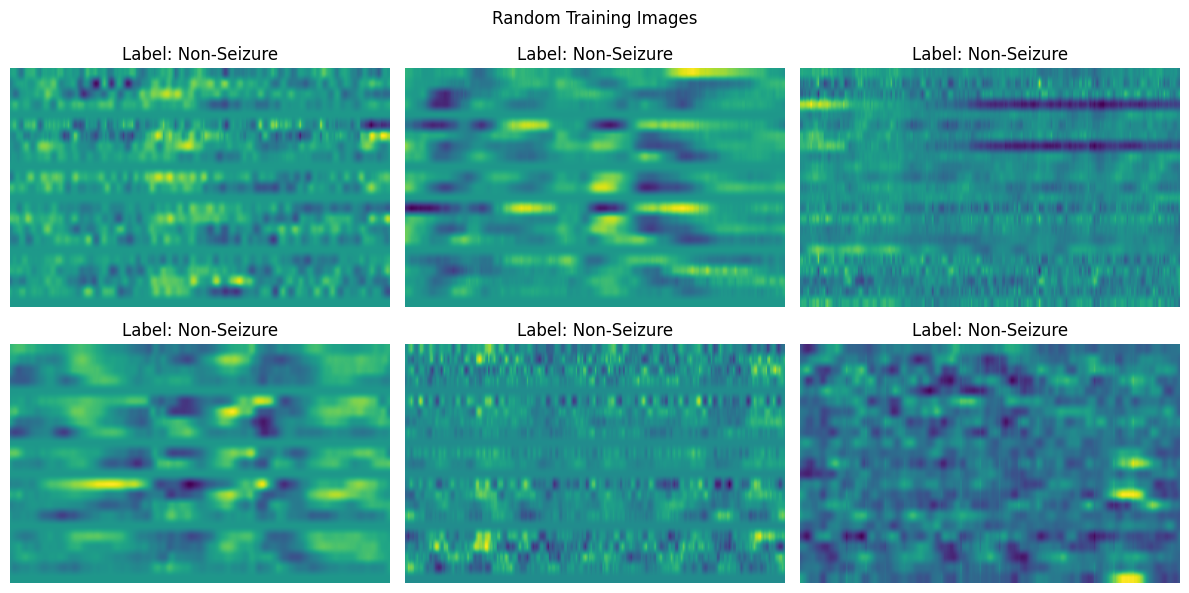

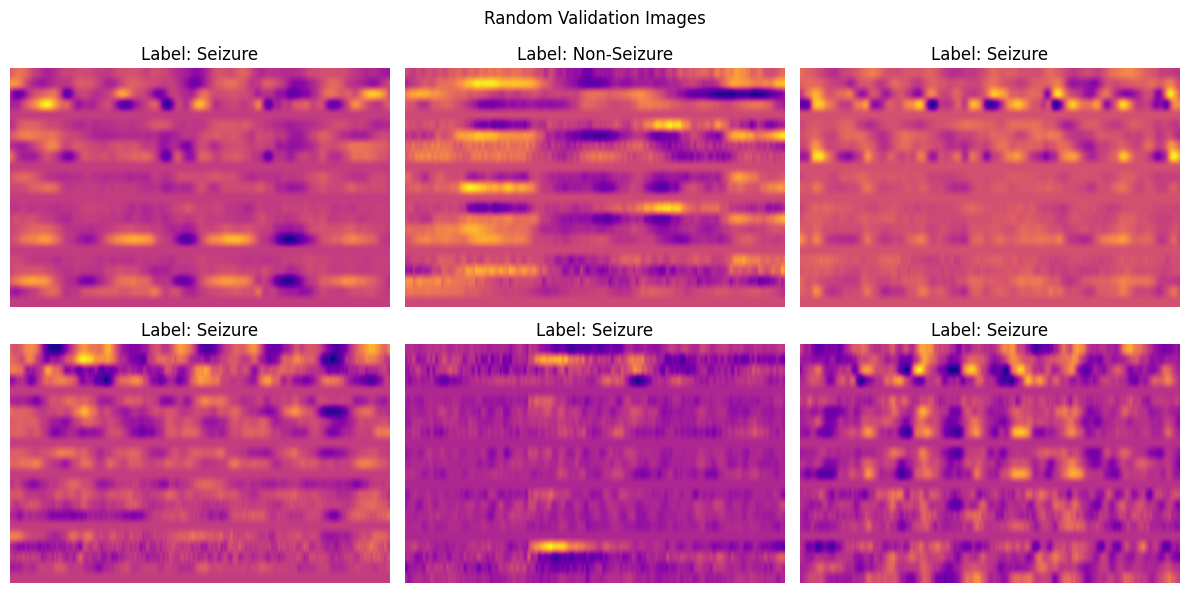

In [53]:
import seaborn as sns

# Generate random images and plots from test_data , val_data and test_data

def plot_random_images(data, labels, title, cmap='viridis'):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        index = np.random.randint(0, len(data))
        plt.subplot(2, 3, i + 1)
        plt.imshow(data[index].numpy().reshape(23, 256), cmap=cmap, aspect='auto')
        plt.title(f'Label: {"Seizure" if labels[index] else "Non-Seizure"}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display random images from training, validation, and test sets with different color maps
plot_random_images(X_train, y_train, 'Random Training Images', cmap='viridis')
plot_random_images(X_val, y_val, 'Random Validation Images', cmap='plasma')



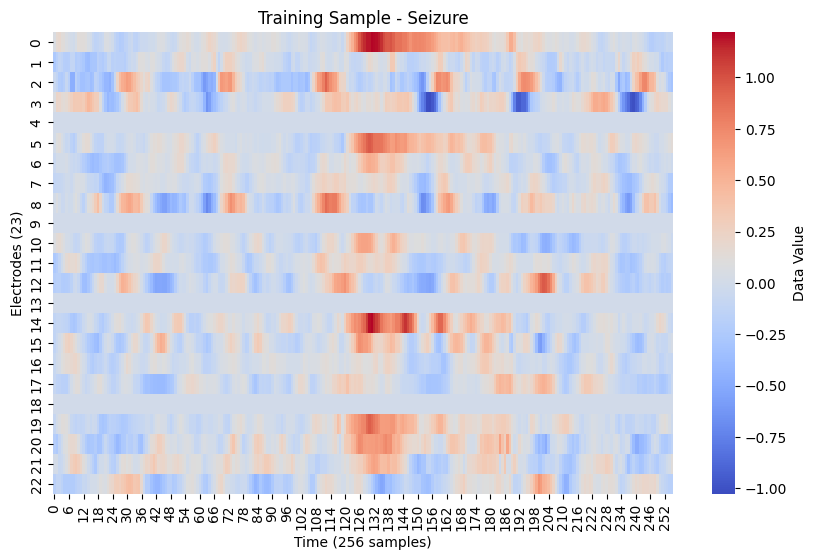

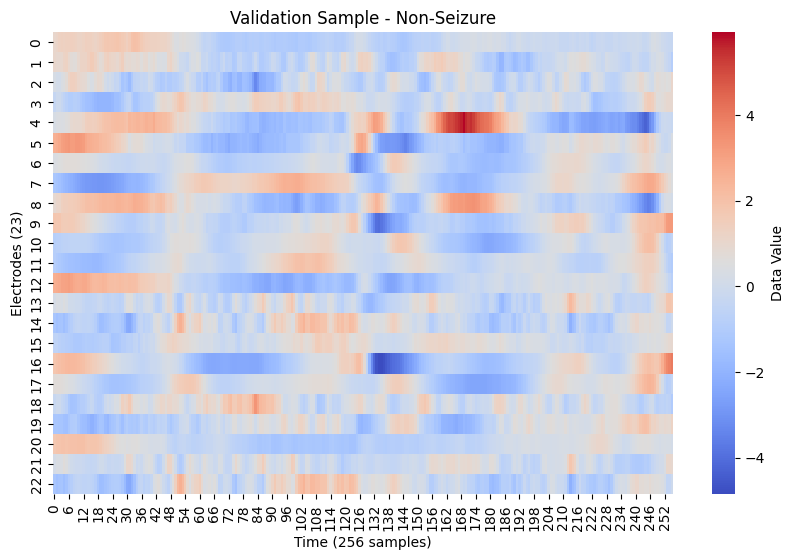

In [51]:
def plot_heatmap(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()  # Convert the tensor to a numpy array
    df = pd.DataFrame(data[index].numpy().reshape(23, 256))
    sns.heatmap(df, cmap='coolwarm', cbar=True, cbar_kws={'label': 'Data Value'})
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (256 samples)')
    plt.ylabel('Electrodes (23)')
    plt.show()

# Plot heatmap for random samples from training, validation, and test sets
plot_heatmap(X_train, y_train, np.random.randint(0, len(X_train)), 'Training Sample')
plot_heatmap(X_val, y_val, np.random.randint(0, len(X_val)), 'Validation Sample')

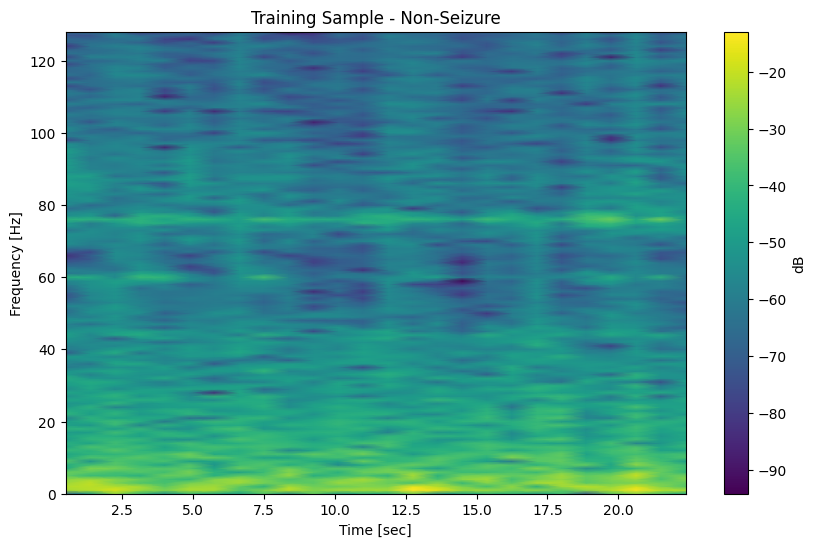

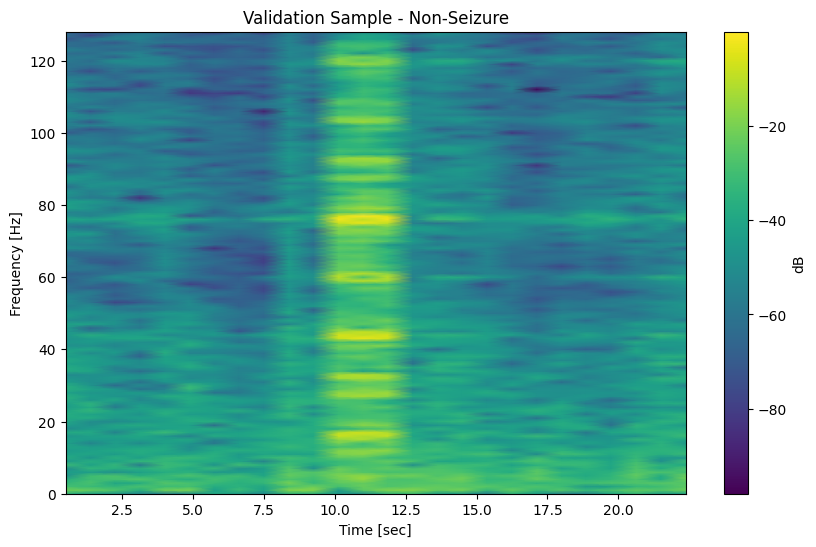

In [59]:
from scipy.signal import spectrogram

# Function to plot spectrogram
def plot_spectrogram(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    f, t, Sxx = spectrogram(data[index].numpy().flatten(), fs=256)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='dB')
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


# Plot spectrogram for random samples from training and validation sets
plot_spectrogram(X_train, y_train, np.random.randint(0, len(X_train)), 'Training Sample')
plot_spectrogram(X_val, y_val, np.random.randint(0, len(X_val)), 'Validation Sample')




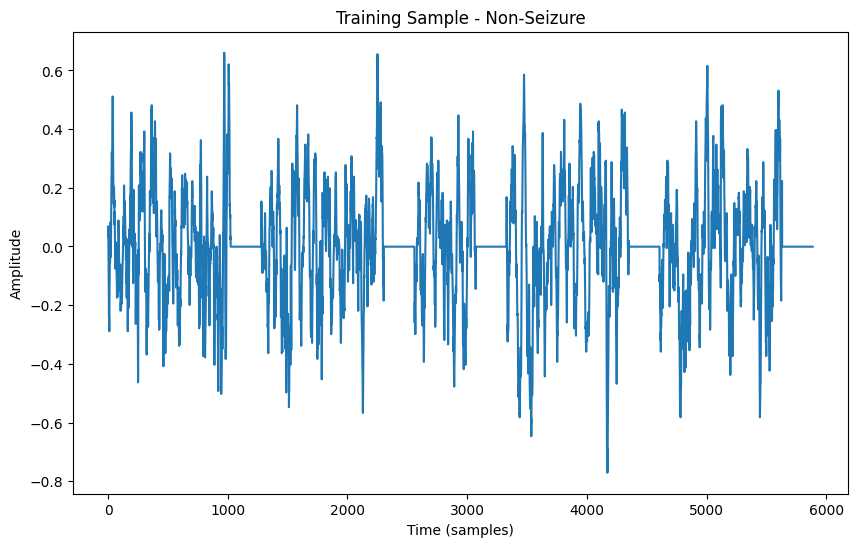

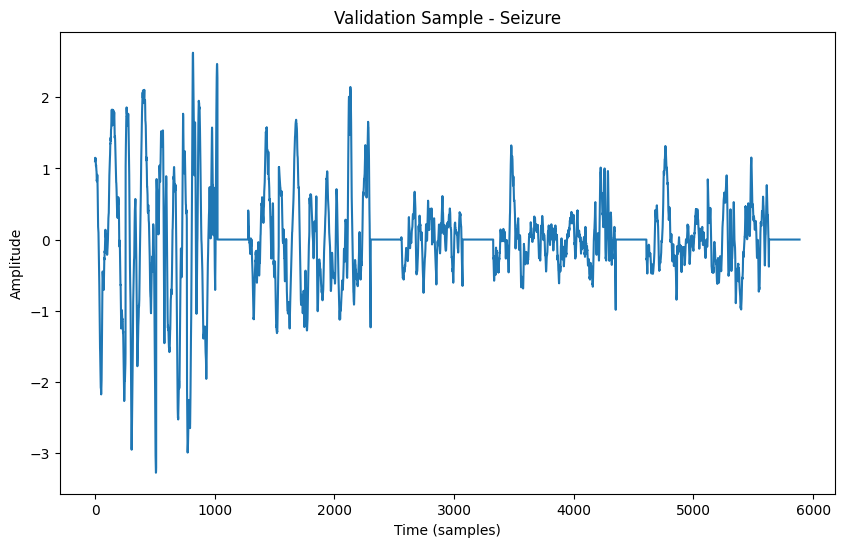

In [61]:
# Function to plot time-series data
def plot_time_series(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    plt.plot(data[index].numpy().flatten())
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

# Plot time-series data for random samples from training and validation sets
plot_time_series(X_train, y_train, np.random.randint(0, len(X_train)), 'Training Sample')
plot_time_series(X_val, y_val, np.random.randint(0, len(X_val)), 'Validation Sample')